In [1]:
# Cost function modelling the University of the Caribbean Lands scenario
#
# Parameters (beside the debug flag, which is boolean), passed as a list:
#    * x[0], fraction of the investment to go to School of Agronomy (A)
#    * x[1], fraction of the investment to go to School of Business (B)
#    * x[2], fraction of the investment to go to School of Computing (C)
#
# Contract/precondition: All x[i] >= 0, sum over all x[i] <= 1.
# The remainder is understood to go into Dormitories (D).
#
# The function returns a list with the predicted outcome for the three minimization objectives:
#    * first element y_0: Decrease in research strength within five years,
#      quantified by the annual number of citations to papers from the university
#    * second element y_1: Others' share in the real-estate tenancy business (1 - our share),
#      quantified in terms of the fraction of the overall the number of tenants in Pt. Reston
#    * third element y_2: Number of votes against the investment plan in the Grand Council.
#      The Grand Council is assumed to have 60 seats.
#
# Remark: We intentionally return fractional numbers of seats in the Grand Council, i.e.,
# that criterion is treated as a continuous rather than a discrete quantity.
# The same goes for the number of citations to papers.
#
# Justification:
# a) Numerical optimization; it is easier that way for opt.minimize() to walk toward minima.
# b) There is an actual sense in which these values should be floating-point numbers.
#    We are here returning the *expected* outcome for these quantities.
#    This technically would be a weighted average over probabilities for random variables.
#    We are here developing a simple qualitative model, where these random variables are not
#    included explicitly, but both research success and votes do indeed depend on chance.
#
def cost_function(x, debug_output):
    # copy x into a list containing investment fractions
    # if the constraints are violated, all are assumed to be zero
    #
    # note that technically it is not our duty to ensure that the preconditions are met;
    # nonetheless, the scalar optimizer from scipy might not adhere to the contract
    #
    if x[0] >= 0 and x[1] >= 0 and x[2] >= 0 and (x[0] + x[1] + x[2]) <= 1:
        investment_fraction = [x[0], x[1], x[2], 1 - x[0] - x[1] - x[2]]
    else:
        investment_fraction = [0, 0, 0, 0]
    
    # compute the predicted improved research strength for each school,
    # and from these data, compute the prediction for y_0
    # model: square root of research strength responds linearly to investment
    #
    present_sqrt_res_strength = [present_research_strength[i]**0.5 for i in range(3)]
    future_sqrt_res_strength = [present_sqrt_res_strength[i] + \
                                research_response_coefficient*investment_fraction[i] \
                                for i in range(3)]
    future_research_strength = [future_sqrt_res_strength[i]*future_sqrt_res_strength[i] \
                                for i in range(3)]
    research_decrease = 0
    for i in range(3):
        research_decrease += present_research_strength[i] - future_research_strength[i]
    
    # compute the prediction for the tenancy metric y_1
    # model: it responds linearly to investment
    #
    others_tenancy_share = others_tenancy_share_now + tenancy_response_coefficient*investment_fraction[3]
    
    # now predict the vote on the Grand Council:
    # we assume that the council is split into interest groups concerning A, B, C, D
    #
    # each group responds linearly to investment, for a range
    # between minimal expectation (all against) and maximal expectation (all in favour);
    # outside this range, the respective group is all against or all in favour of the proposal
    #
    votes_against = 0
    for i in range(4):
        if min_expectation[i] >= investment_fraction[i]:
            votes_against += council_presence[i]
        elif max_expectation[i] >= investment_fraction[i]:
            fraction_in_favour = (investment_fraction[i] - \
                                  min_expectation[i]) / (max_expectation[i] - min_expectation[i])
            votes_against += (1 - fraction_in_favour) * council_presence[i]
    
    # return the outcome, including debugging output if requested
    #
    y = [research_decrease, others_tenancy_share, votes_against]
    
    if debug_output:
        print("\ninvestment fraction:")
        for i in range(len(investment_fraction)):
            print("\tinvestment_fraction[", i, "]\t=\t", round(100*investment_fraction[i], 3), " %", sep="")
            
        print("\npredicted research strength:")
        for i in range(len(future_research_strength)):
            print("\tfuture_research_strength[", i, "]\t=\t", \
                  round(future_research_strength[i], 1), sep="", end="")
            print("\t(now:\t", present_research_strength[i], ")", sep="")
        
        council_size = 0
        for n in council_presence:
            council_size += n
        print("\npredicted vote in the Grand Council:\n\tFor:", \
             round(council_size - votes_against, 2), "\n\tAgainst:", round(votes_against, 2))
        
        print("\nobjectives:")
        for i in range(len(y)):
            print("\ty[", i, "]\t=\t", round(y[i], 5), sep="")
    return y


# constant coefficients used in the model cost function
#
present_research_strength = [20000, 5000, 2000]  # present research strength of the three schools
research_response_coefficient = 30  # linear response of sqrt(research strength) to investment
others_tenancy_share_now = 0.993  # at present, 99.3% of tenants in Pt. Reston do not rent from us
tenancy_response_coefficient = -0.007  # our share might be doubled if we invest 100% in this
council_presence = [12, 9, 15, 24]  # seats of each of the four factions on the Grand Council
min_expectation = [0.32, 0.08, 0.02, 0.04]  # how much needs to be invested until some vote for the plan
max_expectation = [0.64, 0.12, 0.2, 0.64]  # how much needs to be invested so that all vote for the plan

In [2]:
import random
from scipy.stats import lognorm

# returns a random point in parameter space, for this particular scenario
#
def random_parameters():
    unnormalized = [random.random() for i in range(4)]
    u_sum = 0.0
    for u in unnormalized:  # rescale to unity, since sum of investment fractions is 100%
        u_sum += u
    x = [unnormalized[i] / u_sum for i in range(3)]  # we only include the first three fractions in the list
    return x

# returns a random weighting of the objectives, normalized by their characteristic scale
# log-normal distribution chosen
#
def random_weights():
    return [lognorm.rvs(sigma) / scale for scale in objective_scale]

sigma = 3 # std deviation in logarithm of the random weights
objective_scale = [9000, 0.007, 36]  # scale of outcome expected for each of the objectives

In [3]:
# wrappers for Pareto front construction based on linear combinations and hyperboxing
#
import math
import scipy.optimize as opt

# the first argument, x, is a list containing the parameter values
# the second argument, w, is a list containing the weights associated with each of the objectives
#
def cost_linear_combination(x, w, debug_output):
    combined_cost = 0
    y = cost_function(x, debug_output)
    for i in range(min(len(y), len(w))):
        combined_cost += w[i]*y[i]
    if debug_output:
        print("\nCombined cost measure w[0]y[0] + w[1]y[1] + ... =", round(combined_cost, 5))
    return combined_cost

# the arguments are the initial point x0 and the weights w
#
def linear_combination_optimizer_local(x0, w, epsilon, debug_output):
    # below we define a function inside this function, for which w is fixed;
    # then, only the list x remains as an argument
    def fixed_weight_cost_function(x):
        return cost_linear_combination(x, w, False)
    
    # the function defined above has the right format to be handed over to opt.minimize
    local_minimum = opt.minimize(fixed_weight_cost_function, x0, method='nelder-mead', \
                                 options={'xatol': epsilon})
    
    if debug_output:
        print("weights: ")
        for i in range(len(w)):
            print("\tw[", i, "]\t=\t", round(w[i], 4), sep="")
        cost_linear_combination(local_minimum.x, w, True)
    return list(local_minimum.x)

# runs multiple attempts at local optimization starting from random parameters
#
def linear_combination_optimizer_global(w, epsilon, attempts, debug_output):
    wy_global_min = math.inf
    for i in range(attempts):
        x_local_min = linear_combination_optimizer_local(random_parameters(), w, epsilon, False)
        wy_local_min = cost_linear_combination(x_local_min, w, False)
        if wy_local_min < wy_global_min:
            x_global_min = x_local_min
            wy_global_min = wy_local_min
    if debug_output:
        print("weights: ")
        for i in range(len(w)):
            print("\tw[", i, "]\t=\t", round(w[i], 4), sep="")
        cost_linear_combination(x_global_min, w, True)
    return x_global_min

# the first argument, x, is a list containing the parameter values
# the second argument, w, contains the weights of each objective
# the third argument, yoff, is a list containing hyperboxing offsets for the optimization criteria
#
def cost_hyperboxing(x, w, yoff):
    y = cost_function(x, False)
    ymax_shifted = -math.inf
    for i in range(min(len(y), len(yoff))):
        yi_shifted = w[i]*(y[i] - yoff[i])
        if yi_shifted > ymax_shifted:
            ymax_shifted = yi_shifted
    return ymax_shifted

# the arguments are the initial point x0, the weights w, and the offsets yoff
#
def hyperboxing_optimizer_local(x0, w, yoff, epsilon):
    # below we define a function inside this function, for which yoff is fixed;
    # then, only the list x remains as an argument
    def fixed_offset_cost_function(x):
        return cost_hyperboxing(x, w, yoff)
    
    # the function defined above has the right format to be handed over to opt.minimize
    local_minimum = opt.minimize(fixed_offset_cost_function, x0, method='nelder-mead', \
                                 options={'xatol': epsilon})
    return list(local_minimum.x)

# runs multiple attempts at local optimization starting from random parameters
#
def hyperboxing_optimizer_global(w, yoff, epsilon, attempts):
    ymax_global_min = math.inf
    for i in range(attempts):
        x_local_min = hyperboxing_optimizer_local(random_parameters(), w, yoff, epsilon)
        ymax_local_min = cost_hyperboxing(x_local_min, w, yoff)
        if ymax_local_min < ymax_global_min:
            x_global_min = x_local_min
            ymax_global_min = ymax_local_min
    return x_global_min

In [4]:
# try out three different random linear combinations
#
import random
precision_x = 3.0e-07  # local optimizer settings
global_sampling = 64  # global optimizer settings

for i in range(3):
    print("\n==\nCompromise attempt no. i =", i, end = "\n\n")
    linear_combination_optimizer_global(random_weights(), precision_x, global_sampling, True)


==
Compromise attempt no. i = 0

weights: 
	w[0]	=	0.0001
	w[1]	=	8549.7584
	w[2]	=	0.0047

investment fraction:
	investment_fraction[0]	=	0.494 %
	investment_fraction[1]	=	0.0 %
	investment_fraction[2]	=	0.0 %
	investment_fraction[3]	=	99.506 %

predicted research strength:
	future_research_strength[0]	=	20041.9	(now:	20000)
	future_research_strength[1]	=	5000.0	(now:	5000)
	future_research_strength[2]	=	2000.0	(now:	2000)

predicted vote in the Grand Council:
	For: 24 
	Against: 36

objectives:
	y[0]	=	-41.90581
	y[1]	=	0.98603
	y[2]	=	36

Combined cost measure w[0]y[0] + w[1]y[1] + ... = 8430.51928

==
Compromise attempt no. i = 1

weights: 
	w[0]	=	0.0
	w[1]	=	0.7989
	w[2]	=	0.046

investment fraction:
	investment_fraction[0]	=	4.0 %
	investment_fraction[1]	=	12.0 %
	investment_fraction[2]	=	20.0 %
	investment_fraction[3]	=	64.0 %

predicted research strength:
	future_research_strength[0]	=	20340.8	(now:	20000)
	future_research_strength[1]	=	5522.1	(now:	5000)
	future_research_str

In [5]:
# validate that a candidate point on the Pareto front really isn't dominated
# if this happens, it is indicative of numerical inaccuracy of the optimizer
#
def pareto_optimal(obj_space_point, pareto_front):
    for k in range(len(pareto_front[0])):
        dominated = True
        for i in range(n):
            if obj_space_point[i] < pareto_front[i][k]:
                dominated = False
        if dominated:
            # print("*** domination of obj_space_point =", obj_space_point,\
            #       " by ", [pareto_optimal_compromises[i][k] for i in range(n)], " ***")
            print("*** numerical artefact: point dominated ***")
            return False  # obj_space_point is dominated by another, hence not Pareto optimal
    return True  # no known point on the Pareto front dominates obj_space_point -> validation successful

# checks whether a new point dominates any pre-existing point on the Pareto front
# if this happens, it is indicative of numerical inaccuracy of the optimizer
#
# in that event, the old point gets overwritten
#
def replace_dominated(obj_space_point, par_space_point, pareto_front, pareto_optimal_parameters):
    for k in range(len(pareto_front[0])):
        dominating = True
        for i in range(n):
            if obj_space_point[i] > pareto_front[i][k]:
                dominating = False
        if dominating:
            print("*** numerical artefact: new point dominates a pre-existing point ***")
            for i in range(m):
                pareto_optimal_parameters[i][k] = par_space_point[i]
            for i in range(n):
                pareto_front[i][k] = obj_space_point[i]
            return True
    return False

In [6]:
# compute the Pareto front
#
import math
import random
import numpy as np

m = 3  # number of parameters
n = 3  # number of objectives

num_linear_points = 100  # points on Pareto front to be determined from linear combinations
num_hyper_points = 125   # points on Pareto front to be determined by hyperboxing

precision_x = 3.0e-07  # local optimizer settings
global_sampling = 64  # global optimizer settings

# contains Pareto optimal parameterizations, in parameter space
# 
pareto_optimal_parameters = [[] for i in range(m)]

# contains the points on the Pareto front, in objective space
# 
pareto_optimal_compromises = [[] for i in range(n)]

# size of the relevant range in objective space
#
objective_space_lower = [math.inf for i in range(n)]
objective_space_upper = [-math.inf for i in range(n)]

# now we determine Pareto optimal solutions from a sequence of linear combinations for the two criteria
#
print("Linear combinations:\n======\n")
for j in range(num_linear_points):
    iteration_complete = False
    while not iteration_complete:
        optimum = linear_combination_optimizer_global(random_weights(),\
                                                      precision_x, global_sampling, False)
        cost_measures = cost_function(optimum, False)
        if pareto_optimal(cost_measures, pareto_optimal_compromises):
            if not replace_dominated(cost_measures, optimum,\
                                     pareto_optimal_compromises, pareto_optimal_parameters):
                for i in range(m):
                    pareto_optimal_parameters[i].append(optimum[i])
                    print(round(optimum[i], 5), end="\t")
                print("\t\t", end="")
                for i in range(n):
                    if cost_measures[i] < objective_space_lower[i]:
                        objective_space_lower[i] = cost_measures[i]
                    if cost_measures[i] > objective_space_upper[i]:
                        objective_space_upper[i] = cost_measures[i]
                    pareto_optimal_compromises[i].append(cost_measures[i])
                    print(round(cost_measures[i], 5), end="\t")
                iteration_complete = True
                print()

print("\n\nHyperboxing:\n======\n")
for j in range(num_hyper_points):
    iteration_complete = False
    while not iteration_complete:
        random_offsets = [random.uniform(objective_space_lower[i], \
                                     objective_space_upper[i]) for i in range(n)]
        optimum = hyperboxing_optimizer_global(random_weights(),\
                                               random_offsets, precision_x, global_sampling)
        cost_measures = cost_function(optimum, False)
        if pareto_optimal(cost_measures, pareto_optimal_compromises):
            if not replace_dominated(cost_measures, optimum,\
                                     pareto_optimal_compromises, pareto_optimal_parameters):
                for i in range(m):
                    pareto_optimal_parameters[i].append(optimum[i])
                    print(round(optimum[i], 4), end="\t\t")
                print("\t", end="")
                for i in range(n):
                    if cost_measures[i] < objective_space_lower[i]:
                        objective_space_lower[i] = cost_measures[i]
                    if cost_measures[i] > objective_space_upper[i]:
                        objective_space_upper[i] = cost_measures[i]
                    pareto_optimal_compromises[i].append(cost_measures[i])
                    print(round(cost_measures[i], 4), end="\t\t")
                iteration_complete = True
                print()


Linear combinations:

0.68	0.12	0.2			-7280.88309	0.993	24.0	
0.99978	0.0	0.00017			-9383.51245	0.993	48	
0.0	0.00034	0.0			-1.46369	0.986	36	
0.04	0.12	0.2			-1435.58421	0.98852	12.0	
0.0028	0.00567	0.0			-47.86348	0.98606	36	
0.04	0.12	0.2			-1435.5819	0.98852	12	
0.00495	0.0	0.0			-42.01969	0.98603	36	
0.99998	2e-05	0.0			-9385.18592	0.993	48	
0.0	0.12	0.2			-1094.74701	0.98824	12	
*** numerical artefact: point dominated ***
0.0	0.12	0.2			-1094.73392	0.98824	12.0	
0.04	0.12	0.2			-1435.58239	0.98852	12	
0.99997	0.0	3e-05			-9385.0167	0.993	48	
*** numerical artefact: new point dominates a pre-existing point ***
0.0	0.12	0.2			-1094.73445	0.98824	12	
*** numerical artefact: point dominated ***
0.68	0.12	0.2			-7280.88381	0.993	24.0	
0.0029	7e-05	0.0			-24.89955	0.98602	36	
0.6397	0.0	0.0			-5796.36338	0.99048	35.19926	
1e-05	0.0	0.00064			-1.75997	0.986	36	
*** numerical artefact: new point dominates a pre-existing point ***
1.0	0.0	0.0			-9385.27532	0.993	48	
0.0	0.12	0.2			-1094.7

1e-05	0.0	0.0			-0.10724	0.986	36	
*** numerical artefact: new point dominates a pre-existing point ***
*** numerical artefact: point dominated ***
*** numerical artefact: point dominated ***
0.0	0.12	0.2			-1094.73516	0.98824	12.0	
*** numerical artefact: point dominated ***
*** numerical artefact: point dominated ***
0.0	0.12	0.2			-1094.7689	0.98824	12	
0.0	0.12	0.2			-1094.73531	0.98824	12	
0.68	0.12	0.2			-7280.88385	0.993	24.0	
1.0	0.0	0.0			-9385.27291	0.993	48	
*** numerical artefact: point dominated ***
0.04	0.12	0.2			-1435.57776	0.98852	12.0	
*** numerical artefact: new point dominates a pre-existing point ***
*** numerical artefact: point dominated ***
*** numerical artefact: point dominated ***
*** numerical artefact: point dominated ***
*** numerical artefact: point dominated ***
0.0	0.0	0.0			-0.00226	0.986	36	
*** numerical artefact: point dominated ***
0.99975	0.0	1e-05			-9382.68602	0.993	48	
*** numerical artefact: point dominated ***
*** numerical artefact: point do

0.7705		0.12		0.1094			-7898.316		0.993		31.5527		
0.2142		0.12		0.2			-2953.7992		0.9897		18.969		
0.0		0.1156		0.0002			-503.2525		0.9868		27.9789		
0.0037		0.0		0.0743			-235.5765		0.9865		31.4756		
0.4382		0.12		0.1174			-4740.2681		0.9907		27.0727		
0.783		0.0		0.0			-7195.9418		0.9915		40.9208		
0.1539		0.12		0.2			-2421.6454		0.9893		16.5547		


In [7]:
print("\n\nComputed Pareto front:\n======\n")
for k in range(len(pareto_optimal_parameters[0])):
    for i in range(m):
        print(round(pareto_optimal_parameters[i][k], 5), end="\t")
    print("\t\t", end="")
    for i in range(n):
        print(round(pareto_optimal_compromises[i][k], 5), end="\t")
    print()

print("\nRelevant range in objective space:")
for i in range(n):
    print("\tObjective y[", i, "] from ", round(objective_space_lower[i], 4), " to ", \
          round(objective_space_upper[i], 4), sep = "")



Computed Pareto front:

0.68	0.12	0.2			-7280.88359	0.993	24	
0.99994	0.0	0.0			-9384.6522	0.993	48	
0.00027	0.0	0.0			-2.29493	0.986	36	
0.04	0.12	0.2			-1435.58421	0.98852	12.0	
0.00821	0.0	0.0			-69.68761	0.98606	36	
0.04	0.12	0.2			-1435.5819	0.98852	12	
0.00495	0.0	0.0			-42.01969	0.98603	36	
1.0	0.0	0.0			-9385.25194	0.993	48	
0.0	0.12	0.2			-1094.74701	0.98824	12	
0.0	0.12	0.2			-1094.73392	0.98824	12.0	
0.04	0.12	0.2			-1435.58302	0.98852	12	
1.0	0.0	0.0			-9385.24766	0.993	48	
0.0	0.12	0.2			-1094.73485	0.98824	12	
0.68	0.12	0.2			-7280.88381	0.993	24.0	
0.0029	7e-05	0.0			-24.89955	0.98602	36	
0.6397	0.0	0.0			-5796.36338	0.99048	35.19926	
0.00043	0.0	0.0			-3.63891	0.986	36	
1.0	0.0	0.0			-9385.27532	0.993	48	
0.0	0.12	0.2			-1094.73431	0.98824	12	
0.0005	0.0	0.0			-4.22575	0.986	36	
0.00216	0.0	0.0			-18.34989	0.98602	36	
0.88	0.12	0.0			-8686.08259	0.993	39	
0.00312	0.0	0.0			-26.46421	0.98602	36	
0.04	0.12	0.2			-1435.58262	0.98852	12	
0.0	0.12	0.2			-1094.73516	0.98824

<AxesSubplot:xlabel='cost measure y[0]', ylabel='cost measure y[2]'>

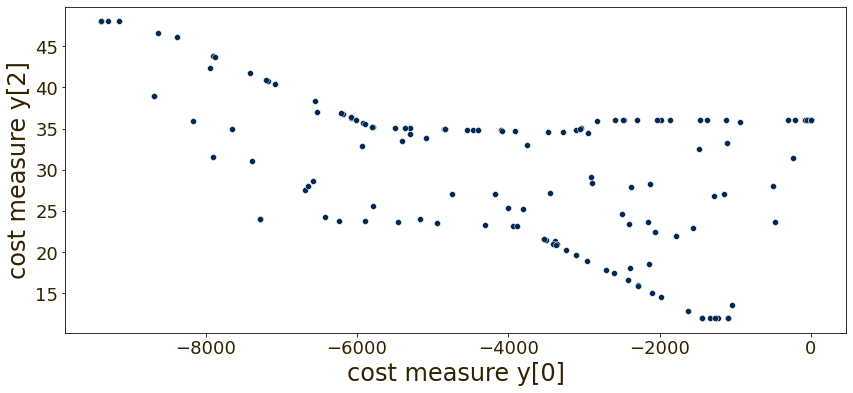

In [8]:
# visualize the whole Pareto front, projected to y[0] and y[2], not showing y[1]
#
import seaborn as sbn
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
plt.xticks(fontsize=18, color="#322300")
plt.yticks(fontsize=18, color="#322300")
ax.set_xlabel("cost measure y[0]", fontsize=24, color="#322300")
ax.set_ylabel("cost measure y[2]", fontsize=24, color="#322300")

# draw the points on the Pareto front jointly with a fifth-order regression
#
sbn.scatterplot(x=pareto_optimal_compromises[0], y=pareto_optimal_compromises[2], \
                color="#002855")

In [9]:
import numpy as np

def square_arrangement(square_size, list_of_values, order_of_indices):
    matrix = np.ndarray((square_size, square_size))
    k = 0
    for i in range(square_size):
        for j in range(square_size-1, -1, -1):
            matrix[i][j] = list_of_values[order_of_indices[k]]
            k += 1
    return matrix

def arrange_indices(square_size, number_of_lists, list_of_lists,\
                    primary_idx, secondary_idx):
    
    index_order_p_idx = [k for (v, k) in\
                         sorted([(v, k) for k, v in\
                                 enumerate(list_of_lists[primary_idx])])]
    index_order_s_idx = [k for (v, k) in\
                         sorted([(v, k) for k, v in\
                                 enumerate(list_of_lists[secondary_idx])])]
    
    index_rank_s = {index_order_s_idx[i]: i for i in range(len(index_order_s_idx))}
    
    order_of_indices = []
    for i in range(square_size-1, -1, -1):
        indices = index_order_p_idx[i*square_size: (i+1)*square_size]
        secondary_ranks = {idx: index_rank_s[idx] for idx in indices}
        secondary_order = [k for (v, k) in sorted([(v, k) for (k, v) in secondary_ranks.items()])]
        for idx in secondary_order:
            order_of_indices.append(idx)
            
    return order_of_indices

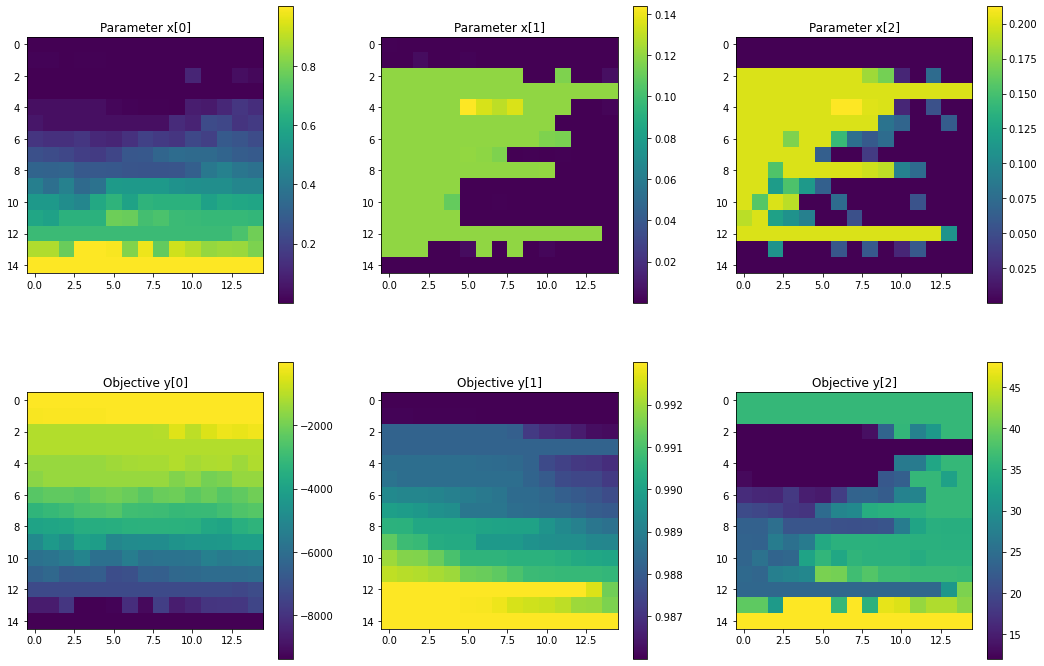

In [13]:
import numpy as np
import seaborn as sbn
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, max(m, n))
fig.set_size_inches(18, 12)

square_size = 15
horizontal_id, vertical_id = np.meshgrid(range(square_size), range(square_size-1, -1, -1))

idx_order = arrange_indices(square_size, n, pareto_optimal_compromises, 0, 1)

for i in range(m):
    # look up Pareto optimal parameter values
    #
    pareto_values = square_arrangement(square_size, pareto_optimal_parameters[i], idx_order)

    axs[0, i].set_title("Parameter x[" + str(i) + "]")
    im = axs[0, i].imshow(pareto_values)
    cbar = axs[0, i].figure.colorbar(im, ax=axs[0, i])

for i in range(n):
    # look up values from the Pareto front
    #
    pareto_values = square_arrangement(square_size, pareto_optimal_compromises[i], idx_order)
    axs[1, i].set_title("Objective y[" + str(i) + "]")
    im = axs[1, i].imshow(pareto_values)
    cbar = axs[1, i].figure.colorbar(im, ax=axs[1, i])